# $\ell_1$ periodogram - tutorial II - what the code does

In this notebook, we dive a little deeper in the details of the implementation of the l1 periodogram. We present the formal definitions of the operations done by the code, and highlight a few differences with the original definition of the method in Hara, Boué, Laskar, Correia (2017), MNRAS (now denoted by HBLC). 


## Step 1: data
Let us assume that we have a time series of $n$ radial velocities, $y = (y_k)_{k=1..n}$ taken at times $t = (t_k)_{k=1..n}$. The total timespan of observations is denoted by $T_\mathrm{obs}$ (attribute 'Tobs' in the code). Our goal is to decompose the data in a sum of sinusoidal functions. 

------
<span style="font-style:italic"> 
Creating the l1p_class with $t$ and $y$ corresponds to step 1 of tutorial I. 
</span> 

-------
## Step 2: model


We here define formally the minimization problem we solve. To do this, let us first define a few quantities. The symbols used in the equation correspond to the name of their corresponding attributes in the class. A table recapitulating the correspondances is given at the end of this cell. 

We consider
- $\|x\|_{\ell_1} = \sum_k |x_k|$ : the $\ell_1$ norm of a vector $x$
- $\|x\|_{\ell_2} = \sqrt{\sum_k x_k^2}$: the $\ell_2$ norm (or Euclidian norm) of a vector $x$
- $\omega_k = k\Delta \omega$,  $k=1..N_\omega$, where $N_\omega$ = floor $\omega_{\mathrm{max}}/\Delta \omega$ a grid of equispaced frequencies in radian/day. $\Delta \omega$ is defined as
$$\Delta \omega := \frac{2\pi}{T_\mathrm{obs}}\frac{1}{N_\mathrm{oversampling}}$$
This is the frequency grid on which we w

- $\phi_k = k\Delta \phi$,   $k=1..N_\phi$ equispaced from 0 included to $\pi$ excluded. 
- $A$ is a $m\times n$ matrix whose elements are sine functions defined on a frequency grid, defined as

<span style="font-size:12pt"> 
(1) $$A_{i,\;jN_\phi +k} =  \cos(\omega_j t_i + \phi_k)$$
</span>

for $i=0..n-1$, $j=0..N_\omega-1$, $k=0..N_\phi-1$. Note that $m = N_\omega N_\phi$
- $V$ is the assumed covariance matrix of the noise ($n \times n$). We denote by $W$ the symmetric matrix such that $W^2 = V^{-1}$ (it exists and is unique).
- $M_{H_0}$ a $n \times n_{H_0}$ matrix: this is a list of $n_{H_0}$ vectors that we assume are in the data. Here, $H_0$ stands for "null hypothesis".

Correspondances between mathematical symbols and class attributes:

| Symbol | Class attribute |
| ------ | ------ |
| $\omega_{\mathrm{max}}$ | omegamax |
| $N_{\mathrm{oversampling}}$ |frequency oversampling| 
| $N_{\phi}$ | Nphi | 
| $V$ | V | 
| $A$ | A | 
| $M_{H_0}$ |  MH0| 

------
<span style="font-style:italic"> 
Setting the elements above corresponds to setting the model in step 2 of tutorial I. 
</span> 

-------
## Step 3: analysis

### Minimization 
When using the numerical method 'lars", the algorithm solves 

<span style="font-size:12pt"> 
$$(BP) \; \; \; x^\star, u^\star= \arg \min\limits_{x \in \mathbb{R}^m, u\in \mathbb{R}^{n_{H_0}}} \|x\|_{\ell_1} \;\;\text{subject to} \;\;\|Ax + M_{H_0}u - y \|_{\ell_2} < \epsilon $$
</span>

Now, when using the 'gglasso' numerical method, we set $N_\phi$ = 2, meaning we only have $\phi_1 = 0$ and  $\phi_2 = \pi$. We orthonormalize the columns of $A$ that correspond to the same frequency but have different $\phi$ and solve
<span style="font-size:12pt"> 
$$(BP_G) \; \; \; x^\star, u^\star= \arg \min\limits_{x \in \mathbb{R}^m, u\in \mathbb{R}^{n_{H_0}}} \sum\limits_{i=1}^{N_\omega} \sqrt{x_{i,1}^2 + x_{i,2}^2}  \;\;\text{subject to} \;\;\|Ax + M_{H_0}u - y \|_{\ell_2} < \epsilon $$
</span>
where $x_{i,1}$ and $x_{i,2}$ are the coefficients of $x$ corresponding to frequency $\omega_i$ and phases $\phi_1 = 0$ and $\phi_2 = \pi/2$ 

We still need to define $\epsilon$, which is taken as $f\sqrt{n - n_{H_0} - 2}$, where $f$ is a factor > 0, set by the keyword tolfact in the function 'l1_perio', set to one by default. Note that $n - n_{H_0} - 2$ is set in accordance with the mode of the $\chi^2$ distribution: if $y_t$ is the value of the data we would have if no noise was present, then $\|W(y_t - y) \|^2.$ Note that the coefficients of $M_{H_0}$, $u$, are variables but do not appear in the $\ell_1$ norm. 

When setting the numerical method to 'lars', we solve $BP$ with the LARS algorithm with LASSO modification. This algorithm is defined in Efron, Hastie, Johnston & Tibshirani 2004, Ann. Stat. It offers the feature to solve BP for all $\epsilon$ from $+\infty$ to the value set in input of the algorithm (here $f\sqrt{n - n_{H_0} - 2}$). 


When setting the numerical method to 'gglasso', we solve (BP_G) with Yuan & Lin 2006, J. R. Statist. Soc.B. In fact, gglasso solves problems of the form 
<span style="font-size:12pt"> 
$$(\text{Group LASSO}) \; \; \; x^\star, u^\star= \arg \min\limits_{x \in \mathbb{R}^m, u\in \mathbb{R}^{n_{H_0}}} \frac{1}{2}\|Ax + M_{H_0}u - y \|_{\ell_2}^2 + \lambda\sum\limits_{i=1}^{N_\omega} w_i\sqrt{x_{i,1}^2 + x_{i,2}^2} $$
</span>
where $w_i$ are positive weights. 
We then find the appropriate $\lambda$ by dichotomy. 

By default we set the weights to 1. However, it might be desirable to modify the weights. As $w_i$ becomes smaller, it means that adding a component at frequency $i$ becomes "cheaper", it might improve the $\chi^2$ term of the Group LASSO and does not affect too much the right hand side of the problem. The weighting is particularly useful in the famework of "re-weighting": one can solve the Group LASSO problem with $\ell_q$ norms, $0\leqslant q <1$ by solving a sequence of re-weighted Group LASSO, as shown in Foucart & Laï 2009. Our implementation offers a possibility to do this, just set the parameters of the keyword 'reweight_args' in the l1_perio method. For instance

reweight_args = {'Nit':5, 'q':0.5, 'eps':1e-10} 

will make 5 re-weighting iteration, converging to a minimum with $\ell_{0.5}$ norm penalization. 'eps' is a technical parameters, we refer the reader to Foucart & Laï 2009 for more details. 

As a remark, we have found so far the re-weighting less efficient than simply unpenalizing the periods that are found to be significant after a first run oof the $\ell_1$ periodogram.

The implementation of gglasso we use is the FORTRAN 90 version coded by Yuan & Lin, linked to Pyhton via f2py. 



### Smoothing

Once the solution $x^\star$ is computed it is smoothed, meaning the values of $x^\star$ corresponding to neighbouring frequencies are averaged in some sense. This step is motivated by the Corollary 1 in Tang, Bhaskar, Recht 2013 (Proceedings Asilomar). The detailed description of the smoothing is cumbersome and relatively unimportant, we refer the reader to the method 'smooth_solution' in the 'l1periodogram_v1.py' file. 

### Significance evaluation

Once the periodgram is obtained, we evaluate the statistical significance of the peaks. This can be done in two ways. In either way, we compare two linear models with frequencies at the  $n+1$ highest peaks + $M_{H_0}$ versus frequencies at $k$ highest peaks + $M_{H_0}$. In other words, we consider the model

<span style="font-size:12pt"> 
$$ H_k : f(t; A_1,..A_k,B_1,..B_k,\omega_1,...\omega_k,  u) = \sum\limits_{i=1}^k A_i \cos \omega_i t + B_i \sin \omega_i t  + M_{H_0} u + \eta$$
</span>

where $\eta$ is a Gaussian noise of covariance matrix $V$. The likelihood of this model is then 
<span style="font-size:12pt"> 
$$ p(y| A_1,..A_k,B_1,..B_k,\omega_1,...\omega_k,  u) = \frac{1}{\sqrt{2\pi}^n \sqrt{|V|}} \mathrm{e}^{-\frac{1}{2}(y - f(t; A_1,..A_k,B_1,..B_k,\omega_1,...\omega_k,  u))^T V^{-1} (y - f(t; A_1,..A_k,B_1,..B_k,\omega_1,...\omega_k,  u))}$$
</span>

$|V|$ being the determinant of matrix $V$. 
We initialize $\omega_i$ at the frequency of the $i$-th highest peaks. We then optimize the parameters to maximize the likelihood (= minimize the $\chi^2$ of this model with covariance matrix $V$). We then compare the models $H_{k+1}$ and  $H_{k}$ in two ways:
 

### FAP
The significance can be done as in HBLC, meaning we consider the value of the $\chi^2$ of model $M_{n+1}$ as if it was the maximum of a periodogram computed with a base model $M_n$. To compute the false alarm probability (FAP) of peak $n+1$, we then apply the formula of Baluev 2008, MNRAS if keyword 'fap_computation' is set to 'baluev2008' in the 'evaluate_significance' method, or Delisle, Hara & Ségransan 2020 A&A otherwise. The formula of the last paper is shown to be asymptically valid for any choice of covariance matrix. The formula of Baluev 2008 is asymptotically valid for white noise models only, however it provides a good approximation of the the correlated noise case and is marginally faster to compute. 

### Evidence computed with a Laplace approximation 

The model $H_k$ is simple, one can easily compute the Hessian of the likelihood and use the Laplace approximation of evidence as given in Eq. 5 in Kass & Raftery 1995, we then take its logarithm. In our approximation, we assume that all the priors are set to 1, so that they do not affect the formula. To change this, the function 'logEv' in the file 'significance.py' can easily be modified. 

Once the log evidences of models with $n+1$ and $n$ sinusoids have been computed, we compute the differences to obtain an estimate of the log Bayes factor.  

------
<span style="font-style:italic"> 
Solving the problems $BP$ or $BP_G$, smooting the solution and evaluating the peak significance corresponds to step 3 of tutorial I. 
</span> 

------- 


## Differences with the procedure presented in Hara, Boué, Laskar, Correia (2017), MNRAS

The paper HBLC defines a set of procedures to compute the l1 periodogram. We here highlight a few differences with the original method.

The way the frequency grid spacing and the parameters $\epsilon$ are defined here in are much simpler way than in HBLC. We found that simply setting $\epsilon$ to $f\sqrt{n - n_{H_0} - 2}$ offers satisfactory results in general. We therefore drop the tuning parameter $\alpha$ defined in Eq. 16 and dropped the concept of "$\epsilon_{grid}$" in Eq. 17. The grid spacing is also made simpler. We found an oversampling of 12 to always be satisfactory. 

In HBLC, the matrix $A$ columns are defined as $\cos (\omega_i t) $ and $\sin (\omega_i t) $.
We however found that using the group-lasso, or a tighter grid of phases in matrix $A$ (see Eq 1 above) does improve the accuracy of the method at a moderate computational cost. 

HBLC uses the SPGL1 algorithm (van den Berg & Friedlander 2008) to solve basis pursuit. We found the LARS algorithm to have less tricky convergence diagnostics, and to be very robust and fast in our case.

We here introduce the matrix $M_{H_0}$, which is absent from HBLC. This is useful to remove some vectors from the penalization, the coefficients of $M_{H_0}$ are included in the model by default, hence their notation as "null hypothesis" $H_0$. Unpenalizing a vector can be particularly useful when there is a very strong periodic signal in the data, whose amplitude estimate will be biased downwards due to the $\ell_1$ norm. 


</span>

------


## Tuning parameters influence

We now explore a little the finer tuning of the algorithm: how does the grid spacing, tolerance or number of considered phases change ? 


In [1]:
#First, a few imports
import numpy as np
import matplotlib.pyplot as plt
import time
from l1periodogram import l1periodogram_v1, covariance_matrices, combine_timeseries, filter_poly

filepath = 'Data/'

To use gglasso, run the command python -m numpy.f2py -c gglasso.f90 -m gglasso_wrapper in the directory l1periodogram_codes, then restart the kernel.


total time:  1.9491448402404785  s


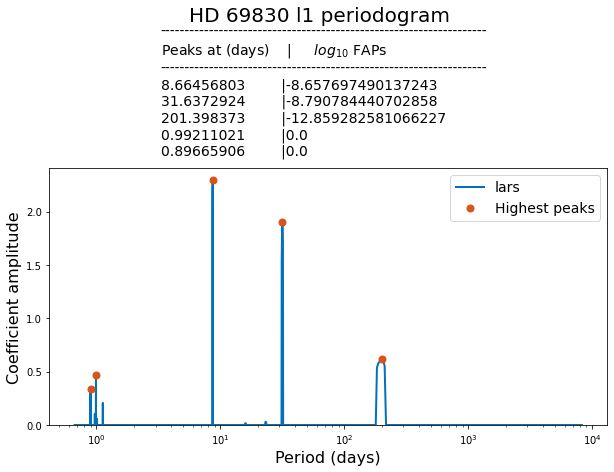

In [2]:

dataset_names = ['HD69830_2006.dat']
dataset_path = [filepath+d for i,d in enumerate(dataset_names)]

#Load the data from the file
T,y,err,offsets,dico, dict_out, dataset_names_out = \
                        combine_timeseries.create_dataset(dataset_path,
                         bintimescale = 0.7)
    
    
# --- Step 1: define the class --- #
c = l1periodogram_v1.l1p_class(T,y)
c.starname = 'HD 69830'
c.dataset_names = dataset_names_out
c.offsets = offsets

# --- Step 2: define the dictionary --- #
sigmaW = 1. #We add in quadrature 1 m/s to the nominal HARPS errors 
sigmaR, tau = 0. ,0. #No red noise
sigma_calib = 0. #No calibration noise
V = covariance_matrices.covar_mat(T,err, sigmaW, sigmaR, sigma_calib,tau)


# Let us begin with the default value of the grid

time0 = time.time()
c.set_model(omegamax = 3*np.pi, 
                   V = V,
                 MH0 = offsets,
                Nphi = 8, 
        oversampling = 10,
             verbose = 0)

# We now compute the l1 periodogram
c.l1_perio(verbose=0,max_n_significance_tests=8, plot_output=False)
c.plot_with_list(5, significance_values = 'log10faps', save = False)
print('total time: ', time.time()-time0, ' s')


Now we take a coarser phase grid, $N_\phi = 2$ instead of $8$.

total time:  1.4028985500335693  s


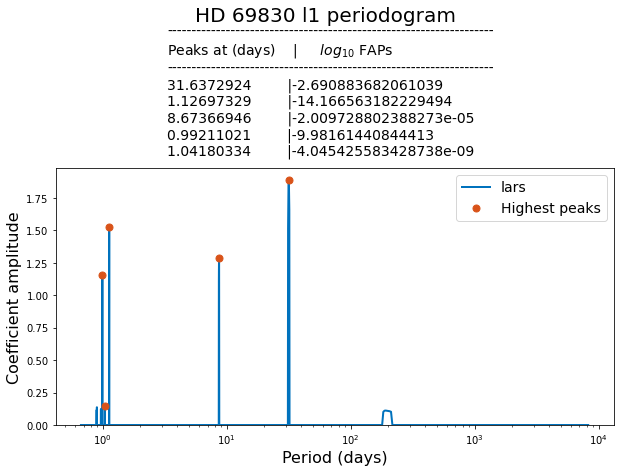

In [3]:
time0 = time.time()
c.set_model(omegamax = 3*np.pi, 
                   V = V,
                 MH0 = offsets,
                Nphi = 2, # <-------- CHANGE
        oversampling = 10, 
             verbose = 0)

c.l1_perio(verbose=0,max_n_significance_tests=8, plot_output=False)
c.plot_with_list(5, significance_values = 'log10faps', save = False)
print('total time: ', time.time()-time0, ' s')

The code is marginally faster, but now the alias of the 201 d period is favoured. Now taking a finer grid, $N_\phi = 20$ instead of $8$.

total time:  2.8791422843933105  s


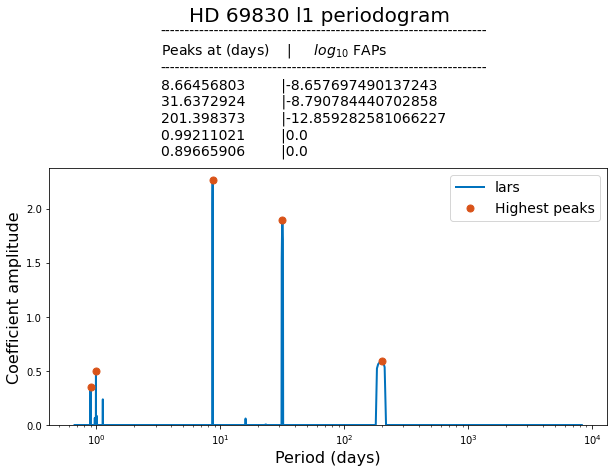

In [4]:
time0 = time.time()
c.set_model(omegamax = 3*np.pi, 
                   V = V,
                 MH0 = offsets,
                Nphi = 20, # <-------- CHANGE
        oversampling = 10, 
             verbose = 0)

c.l1_perio(verbose=0,max_n_significance_tests=8, plot_output=False)
c.plot_with_list(5, significance_values = 'log10faps', save = False)
print('total time: ', time.time()-time0, ' s')

The figure is unchanged and the code takes twice as much time to run. This is not too surprising, as we multiplied the size of matrix $A$ by two.  

------ 

Let us do the same experiment with the frequency grid spacing. Let us first take a coarser grid. 

total time:  1.1560916900634766  s


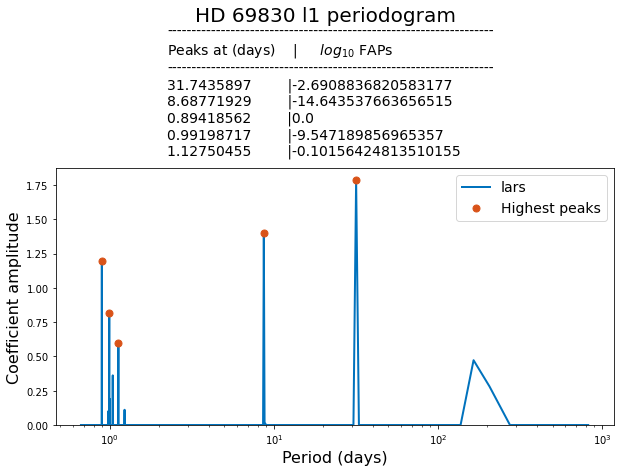

In [5]:
time0 = time.time()
c.set_model(omegamax = 3*np.pi, 
                   V = V,
                 MH0 = offsets,
                Nphi = 8, 
        oversampling = 1, # <-------- CHANGE
             verbose = 0) 

c.l1_perio(verbose=0,max_n_significance_tests=8, plot_output=False)
c.plot_with_list(5, significance_values = 'log10faps', save = False)
print('total time: ', time.time()-time0, ' s')

In that case again, taking too coarse a grid might favour the aliases over the true periods. Now, let us remark that an oversampling of just 2 gives satisfactory results. In the case of systems with many measurements on a very large timespan, it might be worthwile to reduce the grid spacing to improve in computational speed.

total time:  1.3014206886291504  s


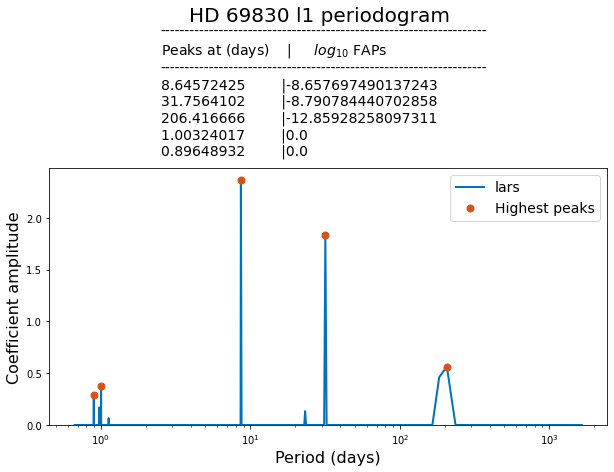

In [6]:
time0 = time.time()
c.set_model(omegamax = 3*np.pi, 
                   V = V,
                 MH0 = offsets,
                Nphi = 8, 
        oversampling = 2, # <-------- CHANGE
             verbose = 0)

c.l1_perio(verbose=0,max_n_significance_tests=8, plot_output=False)
c.plot_with_list(5, significance_values = 'log10faps', save = False)
print('total time: ', time.time()-time0, ' s')

--------------

Now, what happens if we modify the parameter $\epsilon$ in the basis pursuit algorithm? We first take a much smaller tolerance: we want a model much closer to the data. The problem we might anticipate is that by imposing to explain noise with sinusoidal functions, we will pollute the final figure

total time:  3.368093967437744  s


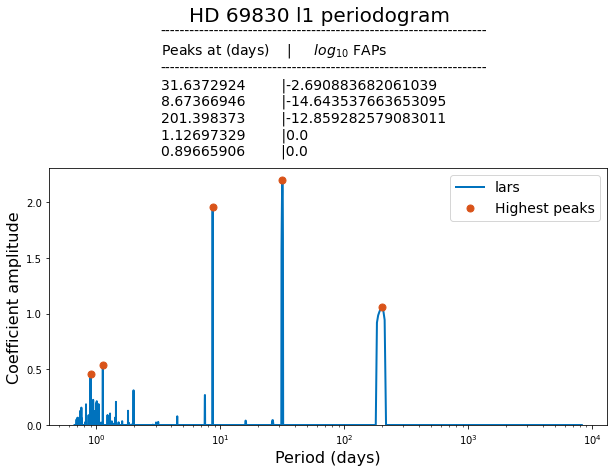

In [7]:
time0 = time.time()
# Back to default grid parameters
c.set_model(omegamax = 3*np.pi, 
                   V = V,
                 MH0 = offsets,
                Nphi = 8, 
        oversampling = 10,
             verbose = 0)

c.l1_perio(tolfact = 0.2, verbose=0,max_n_significance_tests=8, plot_output=False)
c.plot_with_list(5, significance_values = 'log10faps', save = False)
print('total time: ', time.time()-time0, ' s')

Indeed, we see a lot of parasitic peaks in the region of 1 day. An important thing to notice is that the signal is not sparse: our method searches for a simple explanation of the data and yet there are many non zero components. 

<span style="font-weight:bold"> 
A forest of peaks is very symptomatic of too tight a constraint. When it happens for tolfact = 1, it is in general more sound to modify the assumed covariance of the noise and add a jitter term to the observation uncertainties.  
<span style="font-weight:bold">    
    
 Note that however, in the example above, the same three peaks as before are deemed to be significant. 
 
Now, let us see if we go the other way around and make $\epsilon$ larger. We allow the model to be farther from the data. 

There are only 2 peaks
total time:  0.42616748809814453  s


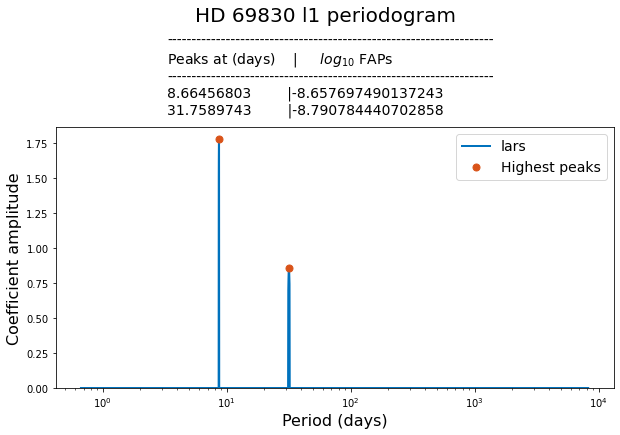

In [8]:
time0 = time.time()

# --- Step 3: compute the l1 periodogram --- #
c.l1_perio(tolfact = 2, # <-------- CHANGE
           verbose=0,max_n_significance_tests=8, plot_output=False)
c.plot_with_list(5, significance_values = 'log10faps', save = False)
print('total time: ', time.time()-time0, ' s')

We have lost the 200 d signal, and the amplitude of the two other signals has decreased. This is the expected behaviour: the minimization of the l1 norm in problem BP tends to push down all the amplitudes of the signals. If a signal is not strictly necessary to verify the condition $\|Ax + M_{H_0}u - y \|_{\ell_2} < \epsilon$, then its amplitude will be 0. 